## Load NDVI and TCI Raster Stacks


In [5]:
import os
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np

# Define your date folders in the desired order.
date_folders = [
    "/Users/chandana/Downloads/May5 2019",
    "/Users/chandana/Downloads/July 14 2019",
    "/Users/chandana/Downloads/July 24 2019",
    "/Users/chandana/Downloads/Aug 1 2019",
    "/Users/chandana/Downloads/Sep 7 2019"
]

# AOI shapefile path.
aoi_shp = "/Users/chandana/Downloads/Small_AOI/Small_AOI_30_03.shp"
aoi = gpd.read_file(aoi_shp)
# Reproject AOI to the imagery CRS (assuming EPSG:32617).
aoi = aoi.to_crs("EPSG:32617")

# Helper function: Crop a raster using provided AOI geometries.
def crop_and_save(input_path, output_path, geometries):
    with rasterio.open(input_path) as src:
        out_image, out_transform = mask(src, geometries, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
    with rasterio.open(output_path, "w", **out_meta) as dst:
        dst.write(out_image)
    print("Saved clipped file:", output_path)

# Process each date folder in the specified order.
for folder in date_folders:
    print("\nProcessing folder:", folder)
    # Define file paths.
    b04_fp = os.path.join(folder, "B04.tif")
    b08_fp = os.path.join(folder, "B08.tif")
    tci_fp = os.path.join(folder, "TCI.tif")
    
    # Create a subfolder for clipped outputs.
    clip_folder = os.path.join(folder, "Clipped_AOI")
    os.makedirs(clip_folder, exist_ok=True)
    
    # Crop and save each file.
    crop_and_save(b04_fp, os.path.join(clip_folder, "B04_AOI.tif"), aoi.geometry.values)
    crop_and_save(b08_fp, os.path.join(clip_folder, "B08_AOI.tif"), aoi.geometry.values)
    crop_and_save(tci_fp, os.path.join(clip_folder, "TCI_AOI.tif"), aoi.geometry.values)
    
    # Compute NDVI from the cropped B04 and B08 images.
    b04_clip_fp = os.path.join(clip_folder, "B04_AOI.tif")
    b08_clip_fp = os.path.join(clip_folder, "B08_AOI.tif")
    ndvi_out_fp = os.path.join(clip_folder, "NDVI_AOI.tif")
    
    with rasterio.open(b04_clip_fp) as src:
        b04_data = src.read(1).astype("float32")
        ndvi_meta = src.meta.copy()
    with rasterio.open(b08_clip_fp) as src:
        b08_data = src.read(1).astype("float32")
        
    ndvi = (b08_data - b04_data) / (b08_data + b04_data + 1e-6)
    ndvi_meta.update({
        "count": 1,
        "dtype": "float32"
    })
    with rasterio.open(ndvi_out_fp, "w", **ndvi_meta) as dst:
        dst.write(ndvi, 1)
    print("Saved NDVI for folder:", folder)

# Now, stack the NDVI and TCI images from all date folders in the given order.
stacked_ndvi_list = []
stacked_tci_list = []
ref_transform = None
ref_crs = None

for folder in date_folders:
    clip_folder = os.path.join(folder, "Clipped_AOI")
    ndvi_fp = os.path.join(clip_folder, "NDVI_AOI.tif")
    tci_fp = os.path.join(clip_folder, "TCI_AOI.tif")
    
    # Read NDVI image.
    with rasterio.open(ndvi_fp) as src:
        ndvi_img = src.read(1)  # Single band image.
        if ref_transform is None:
            ref_transform = src.transform
            ref_crs = src.crs
    # Read TCI image.
    with rasterio.open(tci_fp) as src:
        tci_img = src.read()  # Shape: (3, rows, cols)
    
    stacked_ndvi_list.append(ndvi_img)
    stacked_tci_list.append(tci_img)

# Create stacked arrays.
stacked_ndvi = np.stack(stacked_ndvi_list, axis=0)  # Shape: (n_dates, rows, cols)
stacked_tci = np.concatenate(stacked_tci_list, axis=0)  # Each date contributes 3 bands.

# Create an output folder for the stacked files.
stacked_folder = "/Users/chandana/Downloads/Stacked_Files"
os.makedirs(stacked_folder, exist_ok=True)

# Save the stacked NDVI.
ndvi_stack_path = os.path.join(stacked_folder, "NDVI_Stack.tif")
with rasterio.open(os.path.join(date_folders[0], "Clipped_AOI", "NDVI_AOI.tif")) as src:
    ndvi_meta = src.meta.copy()
ndvi_meta.update({
    "count": stacked_ndvi.shape[0],
    "dtype": stacked_ndvi.dtype,
    "height": stacked_ndvi.shape[1],
    "width": stacked_ndvi.shape[2],
    "transform": ref_transform,
    "crs": ref_crs
})
with rasterio.open(ndvi_stack_path, "w", **ndvi_meta) as dst:
    for i in range(stacked_ndvi.shape[0]):
        dst.write(stacked_ndvi[i, :, :], i+1)
print("Stacked NDVI saved at:", ndvi_stack_path)

# Save the stacked TCI.
tci_stack_path = os.path.join(stacked_folder, "TCI_Stack.tif")
with rasterio.open(os.path.join(date_folders[0], "Clipped_AOI", "TCI_AOI.tif")) as src:
    tci_meta = src.meta.copy()
tci_meta.update({
    "count": stacked_tci.shape[0],
    "dtype": stacked_tci.dtype,
    "height": stacked_tci.shape[1],
    "width": stacked_tci.shape[2],
    "transform": ref_transform,
    "crs": ref_crs
})
with rasterio.open(tci_stack_path, "w", **tci_meta) as dst:
    for i in range(stacked_tci.shape[0]):
        dst.write(stacked_tci[i, :, :], i+1)
print("Stacked TCI saved at:", tci_stack_path)



Processing folder: /Users/chandana/Downloads/May5 2019
Saved clipped file: /Users/chandana/Downloads/May5 2019/Clipped_AOI/B04_AOI.tif
Saved clipped file: /Users/chandana/Downloads/May5 2019/Clipped_AOI/B08_AOI.tif
Saved clipped file: /Users/chandana/Downloads/May5 2019/Clipped_AOI/TCI_AOI.tif
Saved NDVI for folder: /Users/chandana/Downloads/May5 2019

Processing folder: /Users/chandana/Downloads/July 14 2019
Saved clipped file: /Users/chandana/Downloads/July 14 2019/Clipped_AOI/B04_AOI.tif
Saved clipped file: /Users/chandana/Downloads/July 14 2019/Clipped_AOI/B08_AOI.tif
Saved clipped file: /Users/chandana/Downloads/July 14 2019/Clipped_AOI/TCI_AOI.tif
Saved NDVI for folder: /Users/chandana/Downloads/July 14 2019

Processing folder: /Users/chandana/Downloads/July 24 2019
Saved clipped file: /Users/chandana/Downloads/July 24 2019/Clipped_AOI/B04_AOI.tif
Saved clipped file: /Users/chandana/Downloads/July 24 2019/Clipped_AOI/B08_AOI.tif
Saved clipped file: /Users/chandana/Downloads/July

NDVI Stack shape: (5, 336, 451)


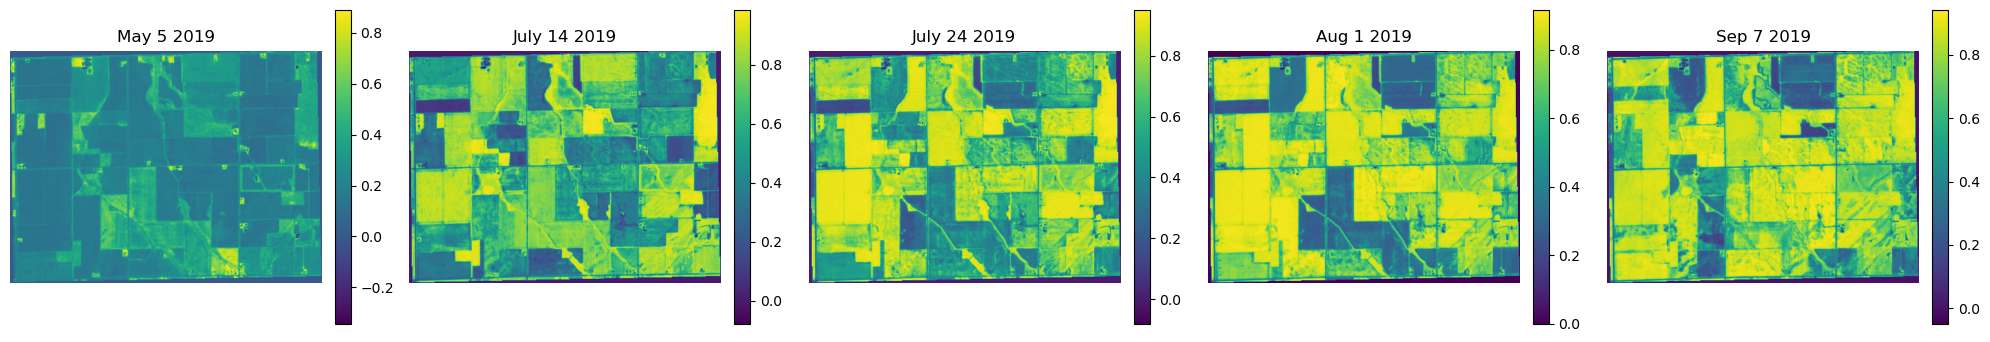

In [6]:
import rasterio
import matplotlib.pyplot as plt

ndvi_stack_path = "/Users/chandana/Downloads/Stacked_Files/NDVI_Stack.tif"

with rasterio.open(ndvi_stack_path) as src:
    ndvi_stack = src.read()  # shape: (n_dates, rows, cols)

n_dates, rows, cols = ndvi_stack.shape
print("NDVI Stack shape:", ndvi_stack.shape)

# Define your date labels in the desired order.
date_labels = ["May 5 2019", "July 14 2019", "July 24 2019", "Aug 1 2019", "Sep 7 2019"]

fig, axes = plt.subplots(1, n_dates, figsize=(4 * n_dates, 4))
if n_dates == 1:
    axes = [axes]
for i in range(n_dates):
    ax = axes[i]
    im = ax.imshow(ndvi_stack[i, :, :], cmap="viridis")
    ax.set_title(date_labels[i])
    ax.axis("off")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


TCI Stack shape: (15, 336, 451)


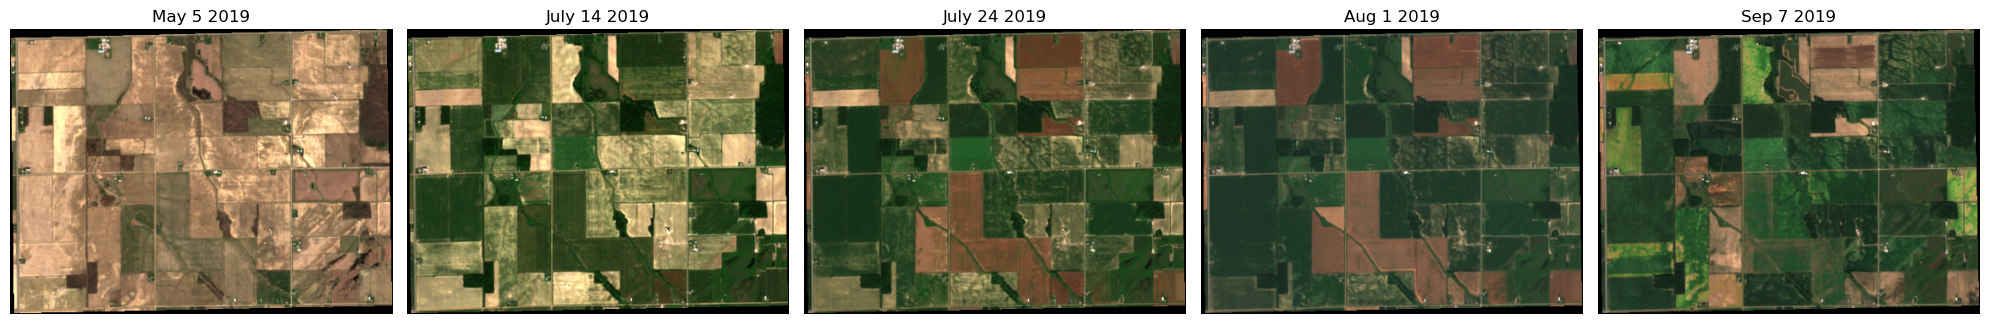

In [7]:
import rasterio
import matplotlib.pyplot as plt

tci_stack_path = "/Users/chandana/Downloads/Stacked_Files/TCI_Stack.tif"

with rasterio.open(tci_stack_path) as src:
    tci_stack = src.read()  # shape: (n_total_bands, rows, cols)

n_total_bands, rows, cols = tci_stack.shape
n_dates_tci = n_total_bands // 3  # each date has 3 bands (RGB)
print("TCI Stack shape:", tci_stack.shape)

# Using the same date labels defined for NDVI:
date_labels = ["May 5 2019", "July 14 2019", "July 24 2019", "Aug 1 2019", "Sep 7 2019"]

fig, axes = plt.subplots(1, n_dates_tci, figsize=(4 * n_dates_tci, 4))
if n_dates_tci == 1:
    axes = [axes]
for i in range(n_dates_tci):
    ax = axes[i]
    # Extract the three bands corresponding to each date and transpose for display (rows, cols, channels)
    rgb = tci_stack[i*3:(i+1)*3, :, :].transpose((1, 2, 0))
    ax.imshow(rgb)
    ax.set_title(date_labels[i])
    ax.axis("off")
plt.tight_layout()
plt.show()


## Preprocessing

In [8]:
import numpy as np

# Assume stacked_ndvi has shape (n_dates, rows, cols)
# For example, with n_dates = 5.
n_dates, rows, cols = stacked_ndvi.shape

# Compute mean NDVI over time per pixel:
ndvi_mean = np.mean(stacked_ndvi, axis=0)

# Compute maximum NDVI per pixel:
ndvi_max = np.max(stacked_ndvi, axis=0)

# Compute minimum NDVI per pixel:
ndvi_min = np.min(stacked_ndvi, axis=0)

# Compute temporal standard deviation:
ndvi_std = np.std(stacked_ndvi, axis=0)

# Optionally, find the index (date) where NDVI is highest per pixel:
ndvi_argmax = np.argmax(stacked_ndvi, axis=0)



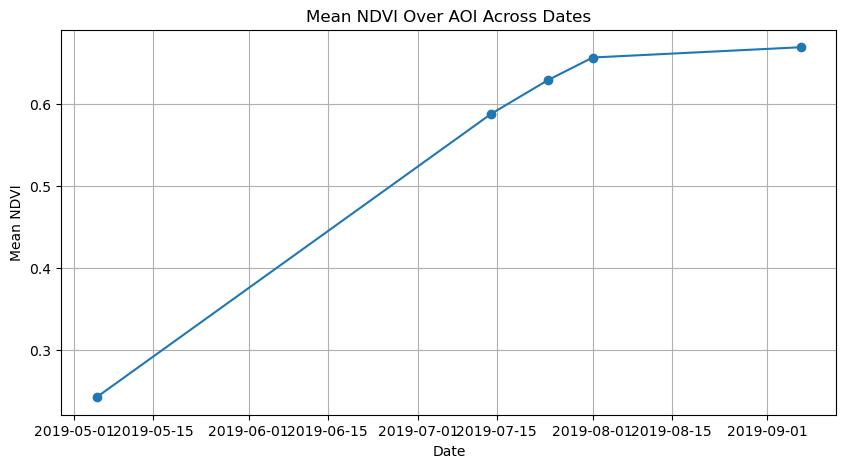

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Compute mean NDVI for each date over the AOI.
# stacked_ndvi has shape (n_dates, rows, cols)
mean_ndvi_per_date = [np.nanmean(stacked_ndvi[i, :, :]) for i in range(n_dates)]

# Define your date order (adjust the dates as you described)
date_labels = ["May 5 2019", "July 14 2019", "July 24 2019", "Aug 1 2019", "Sep 7 2019"]
# Convert labels to a pandas datetime index if possible (here we create a dummy date series)
dates = pd.to_datetime(["2019-05-05", "2019-07-14", "2019-07-24", "2019-08-01", "2019-09-07"])

ndvi_series = pd.Series(mean_ndvi_per_date, index=dates)

plt.figure(figsize=(10, 5))
plt.plot(ndvi_series.index, ndvi_series.values, marker='o')
plt.title("Mean NDVI Over AOI Across Dates")
plt.xlabel("Date")
plt.ylabel("Mean NDVI")
plt.grid(True)
plt.show()


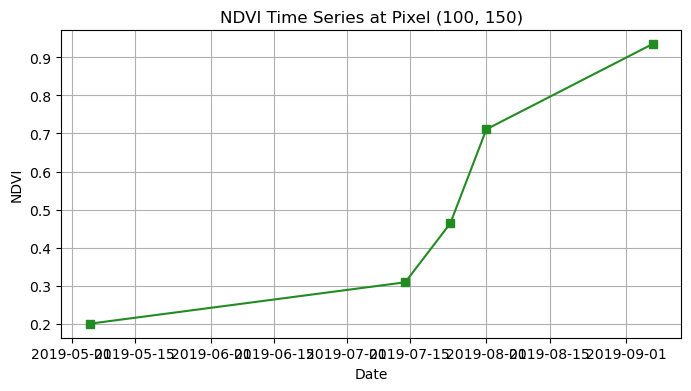

In [10]:
# Select a pixel location
row_idx, col_idx = 100, 150
pixel_ndvi = stacked_ndvi[:, row_idx, col_idx]

plt.figure(figsize=(8, 4))
plt.plot(dates, pixel_ndvi, marker='s', color="forestgreen")
plt.title(f"NDVI Time Series at Pixel ({row_idx}, {col_idx})")
plt.xlabel("Date")
plt.ylabel("NDVI")
plt.grid(True)
plt.show()


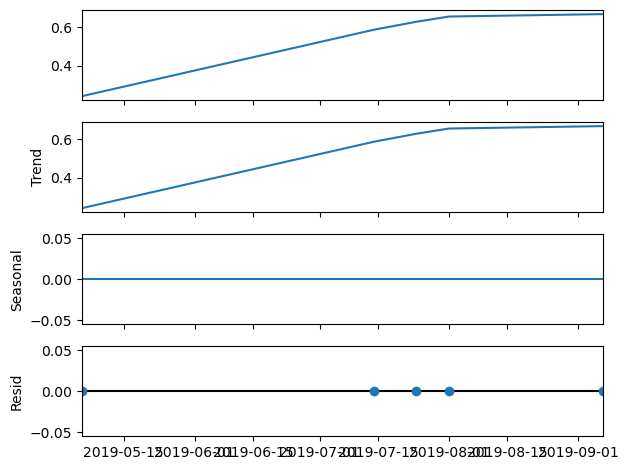

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

# For a simple example, ensure your series has the correct frequency – here we use monthly start (if applicable)
ndvi_series.index = pd.DatetimeIndex(ndvi_series.index)
# Decompose (using 'additive' or 'multiplicative' based on your data distribution)
decomposition = seasonal_decompose(ndvi_series, model='additive', period=1)
decomposition.plot()
plt.show()


## Feature Engineering

In [14]:
import numpy as np
import rasterio

# Load the stacked NDVI.
with rasterio.open(ndvi_stack_path) as src:
    stacked_ndvi = src.read()  # shape: (5, rows, cols)
n_dates, rows, cols = stacked_ndvi.shape

# Load the stacked TCI.
with rasterio.open(tci_stack_path) as src:
    stacked_tci = src.read()  # shape: (15, rows, cols)

# Reshape NDVI: each pixel becomes a row with 5 features.
X_ndvi = stacked_ndvi.reshape(n_dates, -1).T  # shape: (rows*cols, 5)

# Reshape TCI: each pixel becomes a row with 15 features.
X_tci = stacked_tci.reshape(stacked_tci.shape[0], -1).T  # shape: (rows*cols, 15)

# Concatenate horizontally to form a 20-dimensional feature vector per pixel.
X_multi = np.hstack([X_ndvi, X_tci])
print("Multi-temporal feature matrix shape:", X_multi.shape)

# Load ground truth mask.
gt_mask_path = "/Users/chandana/Downloads/May29/Clipped_AOI/ground_truth_mask.tif"
with rasterio.open(gt_mask_path) as src:
    gt_mask = src.read(1)  # shape should be (rows, cols)

# Flatten ground truth mask to get label vector.
y_all = gt_mask.flatten()

# Remove pixels that are nodata (assumed to be 255).
valid_idx = (y_all != 255)
X_valid = X_multi[valid_idx]
y_valid = y_all[valid_idx]

print("Valid features shape:", X_valid.shape)
print("Valid labels shape:", y_valid.shape)

# Optional: Check label distribution.
unique, counts = np.unique(y_valid, return_counts=True)
print("Label counts:", dict(zip(unique, counts)))


Multi-temporal feature matrix shape: (151536, 20)
Valid features shape: (151536, 20)
Valid labels shape: (151536,)
Label counts: {0: 37800, 1: 113736}


## Training

In [17]:
import time
from sklearn.model_selection import train_test_split

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Split data (for example, 80% training, 20% validation).
X_train, X_val, y_train, y_val = train_test_split(
    X_valid, y_valid, test_size=0.2, random_state=42, stratify=y_valid
)

# -----------------------------
# Step A: Measure Training Time
# -----------------------------
start_time = time.time()

# Initialize the multi-temporal RF model with OOB score enabled (optional)
clf_mt = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True)
clf_mt.fit(X_train, y_train)

training_time = time.time() - start_time
print("Multi-temporal RF Training Time: {:.4f} seconds".format(training_time))


# -----------------------------
# Step B: Measure Prediction Time
# -----------------------------
start_time = time.time()
y_pred_mt = clf_mt.predict(X_val)
prediction_time = time.time() - start_time
print("Multi-temporal RF Prediction Time on validation set: {:.4f} seconds".format(prediction_time))

# Calculate validation accuracy and print confusion matrix and classification report
acc_mt = accuracy_score(y_val, y_pred_mt)
print("Multi-temporal RF Validation Accuracy: {:.4f}".format(acc_mt))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_mt))
print("Classification Report:\n", classification_report(y_val, y_pred_mt, target_names=["Non-field", "Field"]))


# -----------------------------
# Step C: Evaluate Model Complexity
# -----------------------------
# For each decision tree in the forest, compute its maximum depth and node count.
tree_depths = [estimator.tree_.max_depth for estimator in clf_mt.estimators_]
tree_nodes  = [estimator.tree_.node_count for estimator in clf_mt.estimators_]

avg_depth = np.mean(tree_depths)
avg_nodes = np.mean(tree_nodes)

print("Average Maximum Tree Depth: {:.2f}".format(avg_depth))
print("Average Number of Nodes per Tree: {:.2f}".format(avg_nodes))


# -----------------------------
# Step D: Measure Peak Memory Usage during Training
# -----------------------------
# If you haven't installed memory_profiler, run: pip install memory_profiler
from memory_profiler import memory_usage

def train_multi_temporal_model():
    model = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True)
    model.fit(X_train, y_train)
    return model

mem_usage = memory_usage((train_multi_temporal_model, ))
peak_mem = max(mem_usage)
print("Peak Memory Usage during Training: {:.2f} MB".format(peak_mem))


Multi-temporal RF Training Time: 36.7415 seconds
Multi-temporal RF Prediction Time on validation set: 0.3542 seconds
Multi-temporal RF Validation Accuracy: 0.9700
Confusion Matrix:
 [[ 7038   522]
 [  387 22361]]
Classification Report:
               precision    recall  f1-score   support

   Non-field       0.95      0.93      0.94      7560
       Field       0.98      0.98      0.98     22748

    accuracy                           0.97     30308
   macro avg       0.96      0.96      0.96     30308
weighted avg       0.97      0.97      0.97     30308

Average Maximum Tree Depth: 33.06
Average Number of Nodes per Tree: 7535.48
Peak Memory Usage during Training: 606.19 MB


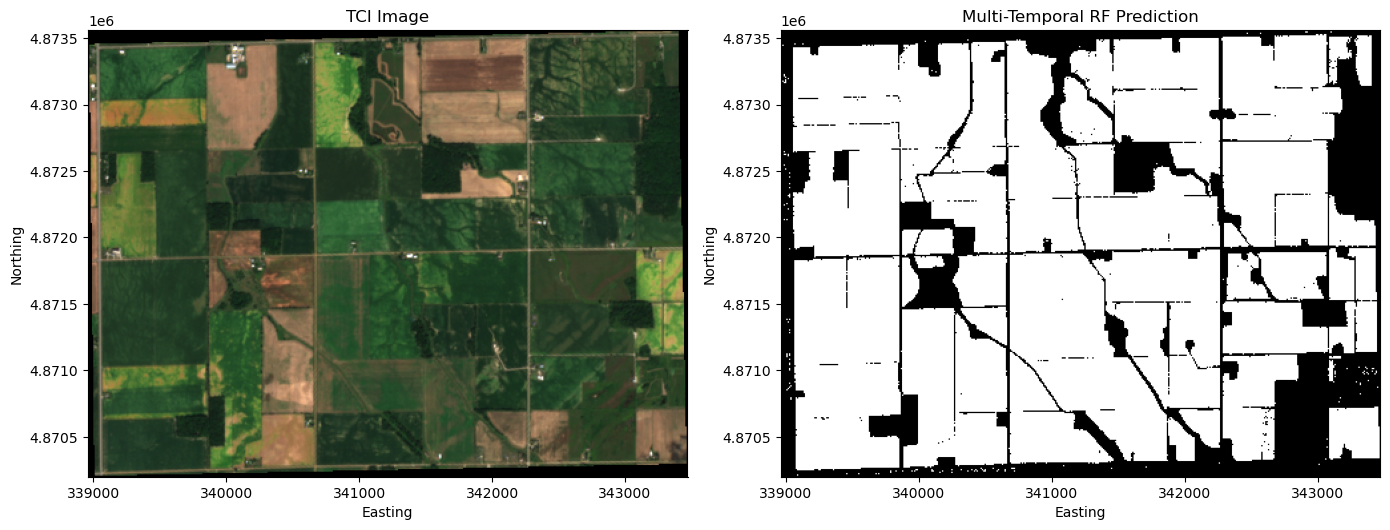

In [20]:
# Predict on all valid pixels. 
# For the full AOI prediction, start by predicting on the entire feature matrix.
y_pred_full = clf_mt.predict(X_multi)
# Create an array for the full prediction with nodata (set nodata as 255 where it was invalid).
pred_full = np.full(y_all.shape, fill_value=255, dtype=y_all.dtype)
pred_full[valid_idx] = y_pred_full
# Reshape to original image shape.
pred_map_multi = pred_full.reshape(rows, cols)

# Visualize the prediction alongside the TCI image (use the first date's TCI for georeferencing).
with rasterio.open(os.path.join(date_folders[4], "Clipped_AOI", "TCI_AOI.tif")) as src:
    tci_data = src.read().transpose((1, 2, 0))
    bounds = src.bounds

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].imshow(tci_data, extent=(bounds.left, bounds.right, bounds.bottom, bounds.top))
axes[0].set_title("TCI Image")
axes[0].set_xlabel("Easting")
axes[0].set_ylabel("Northing")
axes[1].imshow(pred_map_multi, cmap="gray", extent=(bounds.left, bounds.right, bounds.bottom, bounds.top))
axes[1].set_title("Multi-Temporal RF Prediction")
axes[1].set_xlabel("Easting")
axes[1].set_ylabel("Northing")
plt.tight_layout()
plt.show()


In [21]:
import numpy as np
import rasterio

# -----------------------------
# Step 1: Compute IoU for the Field Class
# -----------------------------
# Load the ground truth mask
gt_mask_path = "/Users/chandana/Downloads/May29/Clipped_AOI/ground_truth_mask.tif"
with rasterio.open(gt_mask_path) as src:
    gt_mask = src.read(1)  # shape: (rows, cols)

# Ensure that both ground truth and prediction have only valid pixels:
# (assume nodata in ground truth is 255)
valid = (gt_mask != 255)

# Extract valid pixels from ground truth and prediction.
gt_valid = gt_mask[valid]
pred_valid = pred_map_multi[valid]  # pred_map_multi should be your 2D prediction array

# Compute intersection and union for class 1 (Field)
intersection = np.sum((gt_valid == 1) & (pred_valid == 1))
union = np.sum((gt_valid == 1) | (pred_valid == 1))
iou_field = intersection / union if union > 0 else 0
print("IoU for Field (class 1):", iou_field)

IoU for Field (class 1): 0.9920355686253917


## Acreage Calculation


In [22]:
# Step 2: Calculate Predicted Field Acreage
# -----------------------------
# To compute acreage, we need the area of a single pixel. We use the geotransform
# of a georeferenced image; for example, the clipped TCI image from May29.
tci_aoi_path = "/Users/chandana/Downloads/May29/Clipped_AOI/TCI_AOI.tif"
with rasterio.open(tci_aoi_path) as src:
    transform = src.transform
    # For UTM, pixel size can be computed as:
    pixel_area = abs(transform.a * transform.e)  # in square meters

print("Pixel Area (m²):", pixel_area)

# Count the number of pixels predicted as Field in the full prediction map.
# (We use the entire pred_map_multi even if some pixels were nodata in ground truth.)
pred_field_pixel_count = np.sum(pred_map_multi == 1)

# Compute total predicted area in square meters, then convert to hectares (1 ha = 10,000 m²)
total_area_m2 = pred_field_pixel_count * pixel_area
total_area_ha = total_area_m2 / 10000
# Convert hectares to acres (1 ha ≈ 2.47105 acres)
total_area_acres = total_area_ha * 2.47105

print("Total Predicted Field Area:")
print(f"  {total_area_m2:.2f} m²")
print(f"  {total_area_ha:.2f} ha")
print(f"  {total_area_acres:.2f} acres")

Pixel Area (m²): 100.0
Total Predicted Field Area:
  11387000.00 m²
  1138.70 ha
  2813.78 acres


Zoom bounding box: 340000 4871000 341000 4872000

Processing folder: /Users/chandana/Downloads/May5 2019
Processed date folder: /Users/chandana/Downloads/May5 2019, zoomed NDVI shape: (100, 100), TCI shape: (3, 100, 100)

Processing folder: /Users/chandana/Downloads/July 14 2019
Processed date folder: /Users/chandana/Downloads/July 14 2019, zoomed NDVI shape: (100, 100), TCI shape: (3, 100, 100)

Processing folder: /Users/chandana/Downloads/July 24 2019
Processed date folder: /Users/chandana/Downloads/July 24 2019, zoomed NDVI shape: (100, 100), TCI shape: (3, 100, 100)

Processing folder: /Users/chandana/Downloads/Aug 1 2019
Processed date folder: /Users/chandana/Downloads/Aug 1 2019, zoomed NDVI shape: (100, 100), TCI shape: (3, 100, 100)

Processing folder: /Users/chandana/Downloads/Sep 7 2019
Processed date folder: /Users/chandana/Downloads/Sep 7 2019, zoomed NDVI shape: (100, 100), TCI shape: (3, 100, 100)

Zoomed region dimensions: 100 x 100
Stacked NDVI shape: (5, 100, 100)
Stac

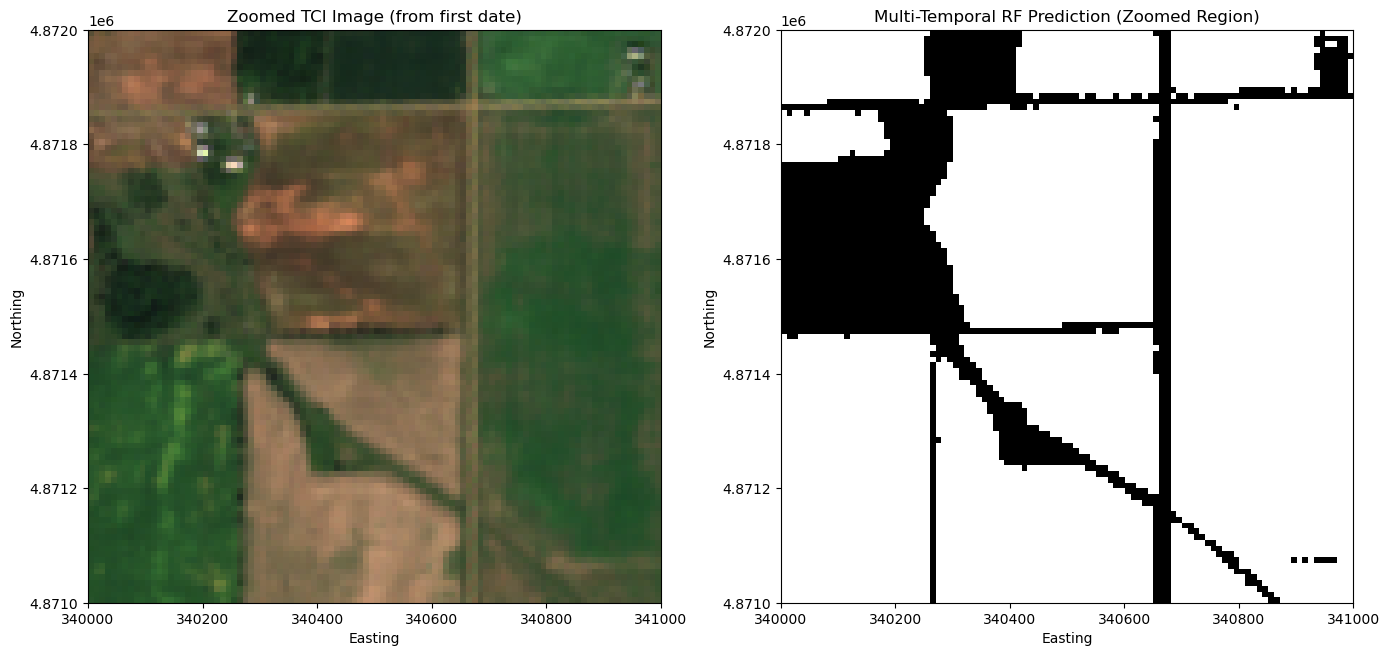

In [24]:
import os
import numpy as np
import rasterio
from rasterio.windows import from_bounds
import matplotlib.pyplot as plt

# Define your date folders in the desired order:
date_folders = [
    "/Users/chandana/Downloads/May5 2019",
    "/Users/chandana/Downloads/July 14 2019",
    "/Users/chandana/Downloads/July 24 2019",
    "/Users/chandana/Downloads/Aug 1 2019",
    "/Users/chandana/Downloads/Sep 7 2019"
]


# -------------------------------------------------------------------
# Step 1: Define the bounding box to "zoom in" (in map coordinates).
# -------------------------------------------------------------------
# You should set these values (new_left, new_bottom, new_right, new_top)
# to define the spatial extent you want to examine.
# For example (these values are illustrative – adjust as needed):
new_left = 340000  # easting (meters)
new_right = 341000
new_bottom = 4871000  # northing (meters)
new_top = 4872000

print("Zoom bounding box:", new_left, new_bottom, new_right, new_top)

# -------------------------------------------------------------------
# Step 2: For each date folder, load the original B04, B08, and TCI, compute NDVI,
# and then extract the zoomed region using the bounding box.
# -------------------------------------------------------------------
ndvi_list = []   # to hold zoomed NDVI for each date (shape: (new_rows, new_cols))
tci_list = []    # to hold zoomed TCI for each date (shape: (3, new_rows, new_cols))
ref_transform = None  # will be set from the first file; assumed consistent among dates

# Loop over date folders in order.
for folder in date_folders:
    print(f"\nProcessing folder: {folder}")
    # Define file paths.
    b04_fp = os.path.join(folder, "B04.tif")
    b08_fp = os.path.join(folder, "B08.tif")
    tci_fp = os.path.join(folder, "TCI.tif")
    
    # Open B04 to set reference (use its CRS and transform)
    with rasterio.open(b04_fp) as src:
        if ref_transform is None:
            ref_transform = src.transform
        # Create a window from the bounding box.
        window = from_bounds(new_left, new_bottom, new_right, new_top, transform=src.transform)
        # Read B04 from the window.
        b04_full = src.read(1).astype("float32")
        b04_zoom = src.read(1, window=window).astype("float32")
    
    # Repeat for B08.
    with rasterio.open(b08_fp) as src:
        b08_zoom = src.read(1, window=window).astype("float32")
    
    # Compute NDVI for the zoom region: NDVI = (B08 - B04) / (B08 + B04 + epsilon)
    epsilon = 1e-6
    ndvi_zoom = (b08_zoom - b04_zoom) / (b08_zoom + b04_zoom + epsilon)
    ndvi_list.append(ndvi_zoom)
    
    # Process TCI – load all three bands and extract window.
    with rasterio.open(tci_fp) as src:
        tci_data = src.read()  # shape: (3, rows, cols)
        # Extract window; no need to transpose now, we keep (bands, rows, cols)
        tci_zoom = src.read(window=window)  # shape: (3, new_rows, new_cols)
        tci_list.append(tci_zoom)
        
    print(f"Processed date folder: {folder}, zoomed NDVI shape: {ndvi_zoom.shape}, TCI shape: {tci_zoom.shape}")

# Verify the shapes (all dates should have same zoom dimensions)
n_dates = len(ndvi_list)
new_rows, new_cols = ndvi_list[0].shape
print(f"\nZoomed region dimensions: {new_rows} x {new_cols}")
    
# -------------------------------------------------------------------
# Step 3: Build the Multi-Temporal Feature Matrix for the Zoom Region.
# Each pixel’s vector: 5 NDVI values (one per date) + 15 TCI values (3 per date) = 20 features.
# -------------------------------------------------------------------
# Stack NDVI: resulting shape (n_dates, new_rows, new_cols)
stacked_ndvi = np.stack(ndvi_list, axis=0)  # shape: (5, new_rows, new_cols)
# Stack TCI: each date gives an array of shape (3, new_rows, new_cols), concatenate along first dimension.
stacked_tci = np.concatenate(tci_list, axis=0)  # shape: (n_dates*3, new_rows, new_cols)
print("Stacked NDVI shape:", stacked_ndvi.shape)
print("Stacked TCI shape:", stacked_tci.shape)

# Reshape NDVI: from (5, new_rows, new_cols) to (new_rows*new_cols, 5)
X_ndvi_zoom = stacked_ndvi.reshape(n_dates, -1).T
# Reshape TCI: from (15, new_rows, new_cols) to (new_rows*new_cols, 15)
X_tci_zoom = stacked_tci.reshape(stacked_tci.shape[0], -1).T

# Concatenate the features to get (new_rows*new_cols, 20)
X_zoom = np.hstack([X_ndvi_zoom, X_tci_zoom])
print("Zoom feature matrix shape:", X_zoom.shape)

# -------------------------------------------------------------------
# Step 4: Predict on the Zoomed Region with the Multi-Temporal RF Model
# -------------------------------------------------------------------
# Make sure clf is the trained multi-temporal model (expecting 20 features per pixel).
y_zoom_pred = clf_mt.predict(X_zoom)

# Reshape predictions back to zoom region dimensions.
pred_zoom_map = y_zoom_pred.reshape(new_rows, new_cols)

# -------------------------------------------------------------------
# Step 5: Visualize the Zoomed-In Region
# -------------------------------------------------------------------
# For visualization, we'll use one of the original TCI images.
# We need to determine a rough map extent for the zoom window.
# We use ref_transform from one of the original files to compute pixel coordinates.
# Use rasterio.windows.bounds() to get geographic bounds of the window.
from rasterio.windows import bounds as window_bounds

# Get geographic bounds of the zoom window as a tuple.
geo_bounds = window_bounds(window, ref_transform)
# Unpack the bounds (left, bottom, right, top)
zoom_left, zoom_bottom, zoom_right, zoom_top = geo_bounds
print("Geographic bounds of zoom region:", geo_bounds)

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# For TCI visualization, use the first date's TCI.
with rasterio.open(os.path.join(date_folders[4], "TCI.tif")) as src:
    tci_full = src.read(window=window)  # shape: (3, new_rows, new_cols)
    # Convert to (rows, cols, channels)
    tci_zoom_vis = tci_full.transpose((1, 2, 0))

axes[0].imshow(tci_zoom_vis, extent=(zoom_left, zoom_right, zoom_bottom, zoom_top))
axes[0].set_title("Zoomed TCI Image (from first date)")
axes[0].set_xlabel("Easting")
axes[0].set_ylabel("Northing")

# Plot predicted classification.
axes[1].imshow(pred_zoom_map, cmap="gray", extent=(zoom_left, zoom_right, zoom_bottom, zoom_top))
axes[1].set_title("Multi-Temporal RF Prediction (Zoomed Region)")
axes[1].set_xlabel("Easting")
axes[1].set_ylabel("Northing")

plt.tight_layout()
plt.show()


## Validation

In [35]:
import os
import numpy as np
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import matplotlib.pyplot as plt

# Define your date folders (in the desired order)
date_folders = [
    "/Users/chandana/Downloads/May5 2019",
    "/Users/chandana/Downloads/July 14 2019",
    "/Users/chandana/Downloads/July 24 2019",
    "/Users/chandana/Downloads/Aug 1 2019",
    "/Users/chandana/Downloads/Sep 7 2019"
]

# AOI shapefile for clipping (new shape file path)
aoi_shp = "/Users/chandana/Downloads/AOI_Huron_24_03/AOI_Huron_24_03.shp"
aoi = gpd.read_file(aoi_shp)
# Ensure AOI is in the expected CRS (assume EPSG:32617) – adjust if needed
aoi = aoi.to_crs("EPSG:32617")

# Helper function: Crop a raster using the provided AOI geometries and save to a given output path.
def crop_and_save(input_path, output_path, geometries):
    with rasterio.open(input_path) as src:
        out_image, out_transform = mask(src, geometries, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
    with rasterio.open(output_path, "w", **out_meta) as dst:
        dst.write(out_image)
    print("Saved clipped file:", output_path)

# For each date folder, clip the B04, B08, and TCI files; then compute and save NDVI.
for folder in date_folders:
    print("\nProcessing folder:", folder)
    # File paths
    b04_fp = os.path.join(folder, "B04.tif")
    b08_fp = os.path.join(folder, "B08.tif")
    tci_fp = os.path.join(folder, "TCI.tif")
    
    # Create a subfolder "test_clip" in each folder to store clipped files.
    clip_folder = os.path.join(folder, "test_clip")
    os.makedirs(clip_folder, exist_ok=True)
    
    # Clip each file using the AOI geometry.
    crop_and_save(b04_fp, os.path.join(clip_folder, "B04_test_clip.tif"), aoi.geometry.values)
    crop_and_save(b08_fp, os.path.join(clip_folder, "B08_test_clip.tif"), aoi.geometry.values)
    crop_and_save(tci_fp, os.path.join(clip_folder, "TCI_test_clip.tif"), aoi.geometry.values)
    
    # Compute NDVI from the clipped B04 and B08.
    b04_clip_fp = os.path.join(clip_folder, "B04_test_clip.tif")
    b08_clip_fp = os.path.join(clip_folder, "B08_test_clip.tif")
    ndvi_out_fp = os.path.join(clip_folder, "NDVI_test_clip.tif")
    
    with rasterio.open(b04_clip_fp) as src:
        b04_data = src.read(1).astype("float32")
        ndvi_meta = src.meta.copy()
    with rasterio.open(b08_clip_fp) as src:
        b08_data = src.read(1).astype("float32")
        
    epsilon = 1e-6
    ndvi = (b08_data - b04_data) / (b08_data + b04_data + epsilon)
    ndvi_meta.update({
        "count": 1,
        "dtype": "float32"
    })
    with rasterio.open(ndvi_out_fp, "w", **ndvi_meta) as dst:
        dst.write(ndvi, 1)
    print("Saved NDVI for folder:", folder)

# -------------------------------------------------------------------
# Step 2: Stack the NDVI and TCI for the Multi-Date Data
# -------------------------------------------------------------------
# We assume that the clipped files are stored in each folder’s "test_clip" subfolder.
ndvi_stack_list = []   # to accumulate NDVI arrays for each date
tci_stack_list = []    # to accumulate TCI arrays for each date

ref_transform = None  # We'll store the transform from the first date
ref_crs = None

for folder in date_folders:
    clip_folder = os.path.join(folder, "test_clip")
    ndvi_fp = os.path.join(clip_folder, "NDVI_test_clip.tif")
    tci_fp = os.path.join(clip_folder, "TCI_test_clip.tif")
    
    # Read NDVI
    with rasterio.open(ndvi_fp) as src:
        ndvi_img = src.read(1)  # shape: (rows, cols)
        if ref_transform is None:
            ref_transform = src.transform
            ref_crs = src.crs
    # Read TCI (expected to have 3 bands)
    with rasterio.open(tci_fp) as src:
        tci_img = src.read()  # shape: (3, rows, cols)
    
    ndvi_stack_list.append(ndvi_img)
    tci_stack_list.append(tci_img)

# Make sure all dates have the same spatial dimensions.
n_dates = len(ndvi_stack_list)
rows = ndvi_stack_list[0].shape[0]
cols = ndvi_stack_list[0].shape[1]
print(f"Each clipped NDVI has shape: ({rows}, {cols})")

# Stack NDVI: resulting array of shape (n_dates, rows, cols)
stacked_ndvi = np.stack(ndvi_stack_list, axis=0)
# Stack TCI: each date gives (3, rows, cols); concatenating along the first axis gives (n_dates*3, rows, cols)
stacked_tci = np.concatenate(tci_stack_list, axis=0)

print("Stacked NDVI shape:", stacked_ndvi.shape)
print("Stacked TCI shape:", stacked_tci.shape)

# Save the stacked files in a common output folder.
stacked_folder = "/Users/chandana/Downloads/Stacked_Files"
os.makedirs(stacked_folder, exist_ok=True)

ndvi_stack_path = os.path.join(stacked_folder, "NDVI_Stack.tif")
with rasterio.open(os.path.join(date_folders[0], "test_clip", "NDVI_test_clip.tif")) as src:
    ndvi_meta = src.meta.copy()
ndvi_meta.update({
    "count": stacked_ndvi.shape[0],
    "dtype": stacked_ndvi.dtype,
    "height": stacked_ndvi.shape[1],
    "width": stacked_ndvi.shape[2],
    "transform": ref_transform,
    "crs": ref_crs
})
with rasterio.open(ndvi_stack_path, "w", **ndvi_meta) as dst:
    for i in range(stacked_ndvi.shape[0]):
        dst.write(stacked_ndvi[i, :, :], i+1)
print("Stacked NDVI saved at:", ndvi_stack_path)

tci_stack_path = os.path.join(stacked_folder, "TCI_Stack.tif")
with rasterio.open(os.path.join(date_folders[0], "test_clip", "TCI_test_clip.tif")) as src:
    tci_meta = src.meta.copy()
tci_meta.update({
    "count": stacked_tci.shape[0],
    "dtype": stacked_tci.dtype,
    "height": stacked_tci.shape[1],
    "width": stacked_tci.shape[2],
    "transform": ref_transform,
    "crs": ref_crs
})
with rasterio.open(tci_stack_path, "w", **tci_meta) as dst:
    for i in range(stacked_tci.shape[0]):
        dst.write(stacked_tci[i, :, :], i+1)
print("Stacked TCI saved at:", tci_stack_path)

# -------------------------------------------------------------------
# Step 3: Build Multi-Temporal Feature Matrix & Test the Model
# -------------------------------------------------------------------
# For each pixel, the feature vector will be:
#  - 5 NDVI values (from stacked_ndvi: shape (n_dates, rows, cols)) and
#  - 15 TCI values (from stacked_tci: shape (n_dates*3, rows, cols))
#
# First, reshape the stacks such that each pixel becomes a row.

X_ndvi = stacked_ndvi.reshape(n_dates, -1).T   # shape: (rows*cols, n_dates)
X_tci = stacked_tci.reshape(stacked_tci.shape[0], -1).T  # shape: (rows*cols, n_dates*3)
X_multi = np.hstack([X_ndvi, X_tci])   # shape: (rows*cols, 5 + 15 = 20)
print("Multi-temporal feature matrix shape:", X_multi.shape)




Processing folder: /Users/chandana/Downloads/May5 2019
Saved clipped file: /Users/chandana/Downloads/May5 2019/test_clip/B04_test_clip.tif
Saved clipped file: /Users/chandana/Downloads/May5 2019/test_clip/B08_test_clip.tif
Saved clipped file: /Users/chandana/Downloads/May5 2019/test_clip/TCI_test_clip.tif
Saved NDVI for folder: /Users/chandana/Downloads/May5 2019

Processing folder: /Users/chandana/Downloads/July 14 2019
Saved clipped file: /Users/chandana/Downloads/July 14 2019/test_clip/B04_test_clip.tif
Saved clipped file: /Users/chandana/Downloads/July 14 2019/test_clip/B08_test_clip.tif
Saved clipped file: /Users/chandana/Downloads/July 14 2019/test_clip/TCI_test_clip.tif
Saved NDVI for folder: /Users/chandana/Downloads/July 14 2019

Processing folder: /Users/chandana/Downloads/July 24 2019
Saved clipped file: /Users/chandana/Downloads/July 24 2019/test_clip/B04_test_clip.tif
Saved clipped file: /Users/chandana/Downloads/July 24 2019/test_clip/B08_test_clip.tif
Saved clipped file

Multi-temporal feature matrix shape: (1315700, 20)
Prediction map shape: (1475, 892)


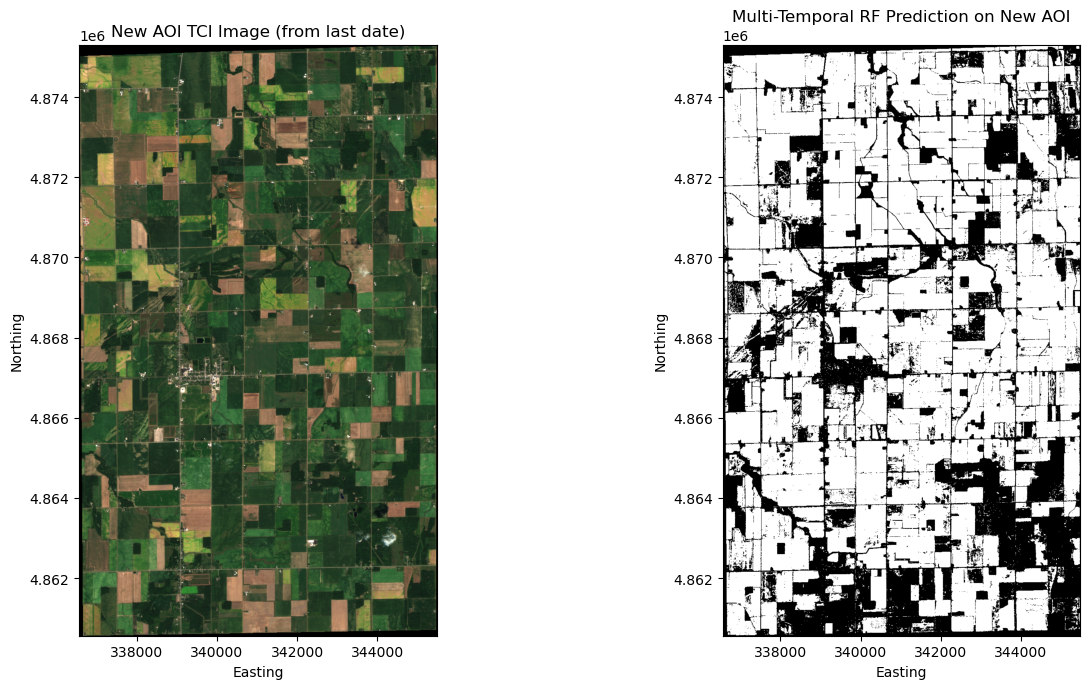

In [36]:
# ----- Step 3: Build Multi-Temporal Feature Matrix & Predict on the New AOI -----
# (Assuming we've already built X_multi as in the previous steps)
print("Multi-temporal feature matrix shape:", X_multi.shape)  # e.g., (rows*cols, 20)

# Predict using the trained multi-temporal RF model (clf)
y_pred_full = clf_mt.predict(X_multi)  # length should equal rows * cols

# Reshape predictions directly using the new AOI's dimensions (rows, cols)
pred_map_multi = y_pred_full.reshape(rows, cols)
print("Prediction map shape:", pred_map_multi.shape)

# ----- Step 4: Visualize the Prediction on the New AOI -----
# We use one of the clipped TCI images for georeferencing.
with rasterio.open(os.path.join(date_folders[-1], "test_clip", "TCI_test_clip.tif")) as src:
    tci_data = src.read().transpose((1, 2, 0))  # (rows, cols, channels)
    bounds = src.bounds

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].imshow(tci_data, extent=(bounds.left, bounds.right, bounds.bottom, bounds.top))
axes[0].set_title("New AOI TCI Image (from last date)")
axes[0].set_xlabel("Easting")
axes[0].set_ylabel("Northing")
axes[1].imshow(pred_map_multi, cmap="gray", extent=(bounds.left, bounds.right, bounds.bottom, bounds.top))
axes[1].set_title("Multi-Temporal RF Prediction on New AOI")
axes[1].set_xlabel("Easting")
axes[1].set_ylabel("Northing")
plt.tight_layout()
plt.show()


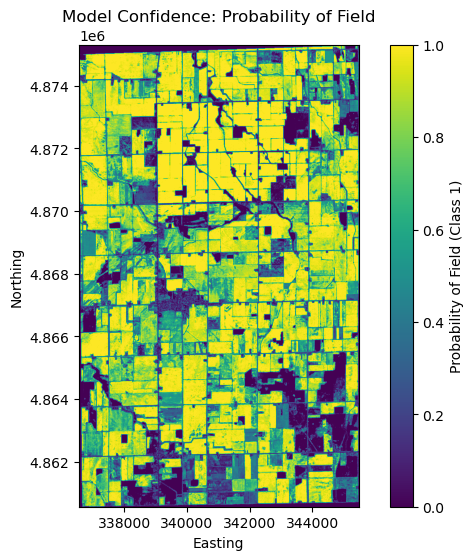

Mean confidence for Field class: 0.6633837880975908


In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Compute predicted probabilities for each pixel.
# X_multi should be of shape (rows*cols, 20)
y_pred_proba = clf_mt.predict_proba(X_multi)  # shape: (n_pixels, n_classes)

# For binary classification, column 0 is class 'non-field' and column 1 is 'field'.
# We extract the probability of the positive ("field") class.
prob_field = y_pred_proba[:, 1]  # shape: (n_pixels,)

# Reshape the probabilities back to the original image dimensions.
# 'rows' and 'cols' must be those of the new AOI clipped images (e.g., rows, cols defined earlier).
prob_field_map = prob_field.reshape(rows, cols)

# Visualize the probability map using a colormap to indicate confidence.
plt.figure(figsize=(8, 6))
# Optionally, set vmin=0 and vmax=1 to span the full probability range.
conf_img = plt.imshow(prob_field_map, cmap='viridis', vmin=0, vmax=1,
                      extent=(bounds.left, bounds.right, bounds.bottom, bounds.top))
plt.colorbar(conf_img, label='Probability of Field (Class 1)')
plt.title("Model Confidence: Probability of Field")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.show()

# (Optional) Print overall statistics:
mean_confidence = np.mean(prob_field)
print("Mean confidence for Field class:", mean_confidence)


In [46]:
import numpy as np
import rasterio

# For calculating pixel area, we open one of the test clipped TCI files
# Here we use the TCI_test_clip.tif from the last date folder (assumed to be September 7, 2019)
import os
tci_test_fp = os.path.join(date_folders[-1], "test_clip", "TCI_test_clip.tif")

with rasterio.open(tci_test_fp) as src:
    transform_new = src.transform
    # Calculate pixel area using the affine transform parameters:
    # Typically, transform.a is pixel width and transform.e is pixel height (often negative)
    pixel_area = abs(transform_new.a * transform_new.e)  # in square meters

print("Pixel Area (m²):", pixel_area)

# Count the number of pixels predicted as "Field" (assumed label '1') in your prediction array.
field_pixel_count = np.sum(pred_map_multi == 1)
print("Number of field pixels:", field_pixel_count)

# Compute total area in square meters.
total_field_area_m2 = field_pixel_count * pixel_area

# Convert square meters to hectares (1 ha = 10,000 m²).
total_field_area_ha = total_field_area_m2 / 10000

# Convert hectares to acres (1 ha ≈ 2.47105 acres).
total_field_area_acres = total_field_area_ha * 2.47105

print("Total Predicted Field Area:")
print(f"  {total_field_area_m2:.2f} m²")
print(f"  {total_field_area_ha:.2f} ha")
print(f"  {total_field_area_acres:.2f} acres")


Pixel Area (m²): 100.0
Number of field pixels: 906628
Total Predicted Field Area:
  90662800.00 m²
  9066.28 ha
  22403.23 acres


In [47]:
import os
import rasterio
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape

# -------------------------------------------------------------------
# Step 1: Write the Test Prediction to a GeoTIFF File
# -------------------------------------------------------------------
# Use one of your test AOI TCI files to extract georeferencing info.
# Here we use the clipped TCI from the new AOI (for example, from the last date folder).
tci_test_fp = os.path.join(date_folders[-1], "test_clip", "TCI_test_clip.tif")

# Define the output path for the prediction GeoTIFF.
output_prediction_tif = "/Users/chandana/Downloads/Stacked_Files/Test_AOI_Prediction.tif"

# Open the reference TCI file to get metadata.
with rasterio.open(tci_test_fp) as src:
    meta = src.meta.copy()
    meta.update({
        "count": 1,                     # single band for prediction,
        "dtype": pred_map_multi.dtype   # e.g., uint8
    })

# Write the prediction array (pred_map_multi) to the new GeoTIFF.
with rasterio.open(output_prediction_tif, "w", **meta) as dst:
    dst.write(pred_map_multi, 1)

print("Prediction GeoTIFF saved at:", output_prediction_tif)

# -------------------------------------------------------------------
# Step 2: Vectorize the Prediction and Save as a Shapefile
# -------------------------------------------------------------------
# The following converts the GeoTIFF to vector polygons for the pixels where the predicted
# class is 1 (assumed to represent fields). Adjust the condition if needed.
polygons = []
with rasterio.open(output_prediction_tif) as src:
    image = src.read(1)  # Read the prediction band
    transform = src.transform
    for geom, val in shapes(image, transform=transform):
        if val == 1:
            polygons.append(shape(geom))

# Create a GeoDataFrame from the polygons.
gdf = gpd.GeoDataFrame({"class": [1]*len(polygons)}, geometry=polygons, crs=src.crs)

# Define output path for the shapefile.
output_shp = "/Users/chandana/Downloads/Stacked_Files/Test_AOI_Prediction.shp"
gdf.to_file(output_shp)
print("Prediction Shapefile saved at:", output_shp)


Prediction GeoTIFF saved at: /Users/chandana/Downloads/Stacked_Files/Test_AOI_Prediction.tif
Prediction Shapefile saved at: /Users/chandana/Downloads/Stacked_Files/Test_AOI_Prediction.shp



Processing folder: /Users/chandana/Downloads/May5 2019
Saved clipped file: /Users/chandana/Downloads/May5 2019/CDL_test_clip/B04_CDL_test_clip.tif
Saved clipped file: /Users/chandana/Downloads/May5 2019/CDL_test_clip/B08_CDL_test_clip.tif
Saved clipped file: /Users/chandana/Downloads/May5 2019/CDL_test_clip/TCI_CDL_test_clip.tif
Saved NDVI for folder: /Users/chandana/Downloads/May5 2019

Processing folder: /Users/chandana/Downloads/July 14 2019
Saved clipped file: /Users/chandana/Downloads/July 14 2019/CDL_test_clip/B04_CDL_test_clip.tif
Saved clipped file: /Users/chandana/Downloads/July 14 2019/CDL_test_clip/B08_CDL_test_clip.tif
Saved clipped file: /Users/chandana/Downloads/July 14 2019/CDL_test_clip/TCI_CDL_test_clip.tif
Saved NDVI for folder: /Users/chandana/Downloads/July 14 2019

Processing folder: /Users/chandana/Downloads/July 24 2019
Saved clipped file: /Users/chandana/Downloads/July 24 2019/CDL_test_clip/B04_CDL_test_clip.tif
Saved clipped file: /Users/chandana/Downloads/Jul

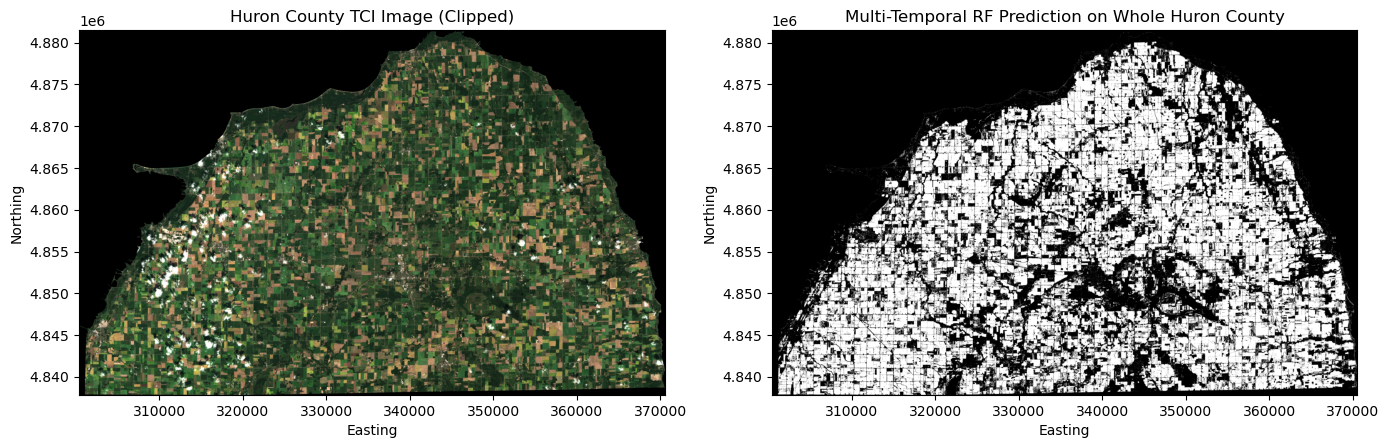

Total Predicted Field Area for Huron County:
  1261288800.00 m²
  126128.88 ha
  311670.77 acres


In [52]:
import os
import numpy as np
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import matplotlib.pyplot as plt

# Define your date folders in the desired order.
date_folders = [
    "/Users/chandana/Downloads/May5 2019",
    "/Users/chandana/Downloads/July 14 2019",
    "/Users/chandana/Downloads/July 24 2019",
    "/Users/chandana/Downloads/Aug 1 2019",
    "/Users/chandana/Downloads/Sep 7 2019"
]

# Huron County AOI shapefile path.
aoi_huron_shp = "/Users/chandana/Downloads/CDL_1756274008/26063.shp"
aoi_huron = gpd.read_file(aoi_huron_shp)
# Reproject to your imagery CRS (assumed EPSG:32617; adjust if necessary)
aoi_huron = aoi_huron.to_crs("EPSG:32617")

# Helper function to crop a raster with given AOI geometries.
def crop_and_save(input_path, output_path, geometries):
    with rasterio.open(input_path) as src:
        out_image, out_transform = mask(src, geometries, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
    with rasterio.open(output_path, "w", **out_meta) as dst:
        dst.write(out_image)
    print("Saved clipped file:", output_path)

# Process each date folder using Huron County AOI.
for folder in date_folders:
    print("\nProcessing folder:", folder)
    # Define original file paths.
    b04_fp = os.path.join(folder, "B04.tif")
    b08_fp = os.path.join(folder, "B08.tif")
    tci_fp = os.path.join(folder, "TCI.tif")
    
    # Create a subfolder "CDL_test_clip" in each folder.
    clip_folder = os.path.join(folder, "CDL_test_clip")
    os.makedirs(clip_folder, exist_ok=True)
    
    # Crop and save B04, B08, and TCI using the Huron County AOI.
    crop_and_save(b04_fp, os.path.join(clip_folder, "B04_CDL_test_clip.tif"), aoi_huron.geometry.values)
    crop_and_save(b08_fp, os.path.join(clip_folder, "B08_CDL_test_clip.tif"), aoi_huron.geometry.values)
    crop_and_save(tci_fp, os.path.join(clip_folder, "TCI_CDL_test_clip.tif"), aoi_huron.geometry.values)
    
    # Compute NDVI for the clipped area.
    b04_clip_fp = os.path.join(clip_folder, "B04_CDL_test_clip.tif")
    b08_clip_fp = os.path.join(clip_folder, "B08_CDL_test_clip.tif")
    ndvi_out_fp = os.path.join(clip_folder, "NDVI_CDL_test_clip.tif")
    
    with rasterio.open(b04_clip_fp) as src:
        b04_data = src.read(1).astype("float32")
        ndvi_meta = src.meta.copy()
    with rasterio.open(b08_clip_fp) as src:
        b08_data = src.read(1).astype("float32")
        
    epsilon = 1e-6
    ndvi = (b08_data - b04_data) / (b08_data + b04_data + epsilon)
    ndvi_meta.update({
        "count": 1,
        "dtype": "float32"
    })
    with rasterio.open(ndvi_out_fp, "w", **ndvi_meta) as dst:
        dst.write(ndvi, 1)
    print("Saved NDVI for folder:", folder)

# -------------------------------------------------------------------
# Step 2: Stack the Clipped NDVI and TCI Files Across All Dates
# -------------------------------------------------------------------
ndvi_stack_list = []   # To accumulate NDVI arrays (each shape: (rows, cols))
tci_stack_list = []    # To accumulate TCI arrays (each shape: (3, rows, cols))
ref_transform = None
ref_crs = None

for folder in date_folders:
    clip_folder = os.path.join(folder, "CDL_test_clip")
    ndvi_fp = os.path.join(clip_folder, "NDVI_CDL_test_clip.tif")
    tci_fp = os.path.join(clip_folder, "TCI_CDL_test_clip.tif")
    
    with rasterio.open(ndvi_fp) as src:
        ndvi_img = src.read(1)  # single band
        if ref_transform is None:
            ref_transform = src.transform
            ref_crs = src.crs
    with rasterio.open(tci_fp) as src:
        tci_img = src.read()  # shape: (3, rows, cols)
    
    ndvi_stack_list.append(ndvi_img)
    tci_stack_list.append(tci_img)

# Check dimensions for consistency.
n_dates = len(ndvi_stack_list)
rows, cols = ndvi_stack_list[0].shape
print(f"Each clipped NDVI has shape: ({rows}, {cols})")

stacked_ndvi = np.stack(ndvi_stack_list, axis=0)  # shape: (n_dates, rows, cols)
stacked_tci = np.concatenate(tci_stack_list, axis=0)  # shape: (n_dates*3, rows, cols)
print("Stacked NDVI shape:", stacked_ndvi.shape)
print("Stacked TCI shape:", stacked_tci.shape)

# Save the stacks to a common output folder.
stacked_folder = "/Users/chandana/Downloads/Stacked_Files"
os.makedirs(stacked_folder, exist_ok=True)

ndvi_stack_path = os.path.join(stacked_folder, "NDVI_Stack_Huron.tif")
with rasterio.open(os.path.join(date_folders[0], "CDL_test_clip", "NDVI_CDL_test_clip.tif")) as src:
    ndvi_meta = src.meta.copy()
ndvi_meta.update({
    "count": stacked_ndvi.shape[0],
    "dtype": stacked_ndvi.dtype,
    "height": stacked_ndvi.shape[1],
    "width": stacked_ndvi.shape[2],
    "transform": ref_transform,
    "crs": ref_crs
})
with rasterio.open(ndvi_stack_path, "w", **ndvi_meta) as dst:
    for i in range(stacked_ndvi.shape[0]):
        dst.write(stacked_ndvi[i, :, :], i+1)
print("Stacked NDVI saved at:", ndvi_stack_path)

tci_stack_path = os.path.join(stacked_folder, "TCI_Stack_Huron.tif")
with rasterio.open(os.path.join(date_folders[0], "CDL_test_clip", "TCI_CDL_test_clip.tif")) as src:
    tci_meta = src.meta.copy()
tci_meta.update({
    "count": stacked_tci.shape[0],
    "dtype": stacked_tci.dtype,
    "height": stacked_tci.shape[1],
    "width": stacked_tci.shape[2],
    "transform": ref_transform,
    "crs": ref_crs
})
with rasterio.open(tci_stack_path, "w", **tci_meta) as dst:
    for i in range(stacked_tci.shape[0]):
        dst.write(stacked_tci[i, :, :], i+1)
print("Stacked TCI saved at:", tci_stack_path)

# -------------------------------------------------------------------
# Step 3: Build the Multi-Temporal Feature Matrix & Predict on Whole Huron County
# -------------------------------------------------------------------
# For each pixel:
#  - NDVI stack provides 5 features (n_dates)
#  - TCI stack provides 15 features (n_dates * 3 bands)
X_ndvi = stacked_ndvi.reshape(n_dates, -1).T  # shape: (rows*cols, n_dates)
X_tci = stacked_tci.reshape(stacked_tci.shape[0], -1).T  # shape: (rows*cols, n_dates*3)
X_multi = np.hstack([X_ndvi, X_tci])  # shape: (rows*cols, 5+15=20)
print("Multi-temporal feature matrix shape:", X_multi.shape)

# Predict using the trained multi-temporal RF model (clf)
y_pred_full = clf_mt.predict(X_multi)
pred_full = y_pred_full.reshape(rows, cols)
print("Prediction map shape:", pred_full.shape)

# -------------------------------------------------------------------
# Step 4: Visualize the Prediction over Whole Huron County
# -------------------------------------------------------------------
# For visualization, we'll use one of the clipped TCI images (e.g., from the first date) for georeferencing.
with rasterio.open(os.path.join(date_folders[4], "CDL_test_clip", "TCI_CDL_test_clip.tif")) as src:
    tci_data_vis = src.read().transpose((1, 2, 0))
    bounds = src.bounds

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].imshow(tci_data_vis, extent=(bounds.left, bounds.right, bounds.bottom, bounds.top))
axes[0].set_title("Huron County TCI Image (Clipped)")
axes[0].set_xlabel("Easting")
axes[0].set_ylabel("Northing")
axes[1].imshow(pred_full, cmap="gray", extent=(bounds.left, bounds.right, bounds.bottom, bounds.top))
axes[1].set_title("Multi-Temporal RF Prediction on Whole Huron County")
axes[1].set_xlabel("Easting")
axes[1].set_ylabel("Northing")
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# Step 5: Calculate Total Predicted Acreage for Huron County
# -------------------------------------------------------------------
# Open the clipped TCI image to get pixel area.
with rasterio.open(os.path.join(date_folders[4], "CDL_test_clip", "TCI_CDL_test_clip.tif")) as src:
    transform_new = src.transform
    pixel_area = abs(transform_new.a * transform_new.e)  # e.g., 100 m² if 10m x 10m

field_pixels = np.sum(pred_full == 1)
total_field_area_m2 = field_pixels * pixel_area
total_field_area_ha = total_field_area_m2 / 10000
total_field_area_acres = total_field_area_ha * 2.47105

print("Total Predicted Field Area for Huron County:")
print(f"  {total_field_area_m2:.2f} m²")
print(f"  {total_field_area_ha:.2f} ha")
print(f"  {total_field_area_acres:.2f} acres")


Full image bounds: BoundingBox(left=300430.0, bottom=4837850.0, right=370570.0, top=4881500.0)


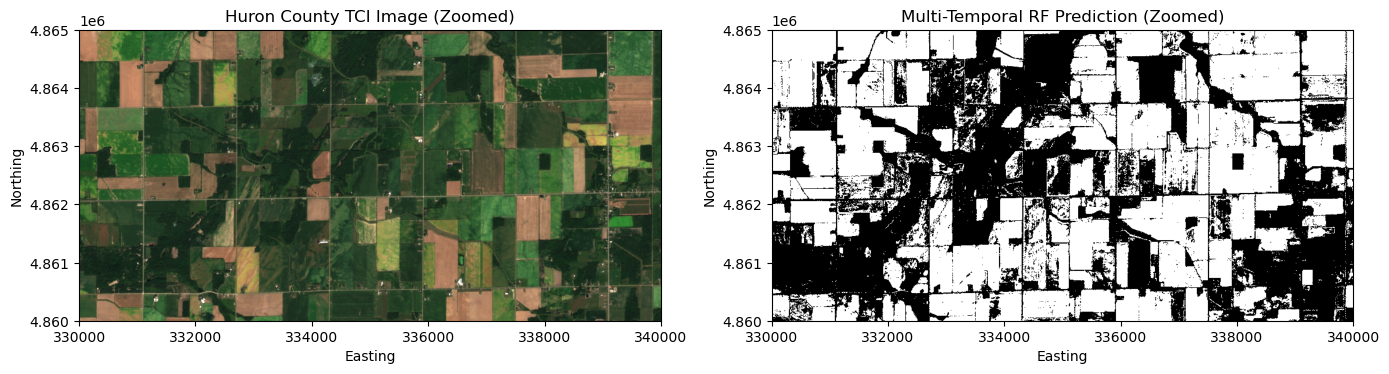

In [50]:
import matplotlib.pyplot as plt

# Define the zoom window in map coordinates.
xrange = (330000, 340000)   # Easting range
yrange = (4860000, 4865000)  # Northing range

# Open one of the clipped TCI images (using the first date as before) to get a background.
with rasterio.open(os.path.join(date_folders[4], "CDL_test_clip", "TCI_CDL_test_clip.tif")) as src:
    tci_data_vis = src.read().transpose((1, 2, 0))  # (rows, cols, 3)
    bounds = src.bounds

# If you need to verify the full image extent:
print("Full image bounds:", bounds)

# Now create a figure for the zoomed region.
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot the TCI image for background.
axes[0].imshow(tci_data_vis, extent=(bounds.left, bounds.right, bounds.bottom, bounds.top))
axes[0].set_title("Huron County TCI Image (Zoomed)")
axes[0].set_xlabel("Easting")
axes[0].set_ylabel("Northing")
# Set the zoom window.
axes[0].set_xlim(xrange)
axes[0].set_ylim(yrange)

# Plot the predicted classification map.
axes[1].imshow(pred_full, cmap="gray", extent=(bounds.left, bounds.right, bounds.bottom, bounds.top))
axes[1].set_title("Multi-Temporal RF Prediction (Zoomed)")
axes[1].set_xlabel("Easting")
axes[1].set_ylabel("Northing")
# Apply the same zoom window.
axes[1].set_xlim(xrange)
axes[1].set_ylim(yrange)

plt.tight_layout()
plt.show()


In [51]:
import os
import rasterio
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape

# -------------------------------------------------------------------
# Step 1: Write the Whole Huron County Prediction to a GeoTIFF
# -------------------------------------------------------------------
tci_ref_fp = os.path.join(date_folders[0], "CDL_test_clip", "TCI_CDL_test_clip.tif")
output_prediction_tif = "/Users/chandana/Downloads/Stacked_Files/Huron_County_Prediction.tif"

# Open the reference TCI file to obtain metadata.
with rasterio.open(tci_ref_fp) as src:
    meta = src.meta.copy()
    # Update meta for a single band GeoTIFF (our prediction map is 2D).
    meta.update({
        "count": 1,
        "dtype": pred_full.dtype  # e.g., if pred_full is uint8
    })

# Write the prediction (pred_full) to a new GeoTIFF file.
with rasterio.open(output_prediction_tif, "w", **meta) as dst:
    dst.write(pred_full, 1)
    
print("Prediction GeoTIFF saved at:", output_prediction_tif)

# -------------------------------------------------------------------
# Step 2: Vectorize the Prediction and Save as a Shapefile
# -------------------------------------------------------------------
# Use the prediction GeoTIFF we just created for vectorization.
polygons = []
# Open the prediction GeoTIFF
with rasterio.open(output_prediction_tif) as src:
    prediction = src.read(1)  # Read the single band prediction
    transform = src.transform
    # Iterate over the shapes in the raster
    for geom, value in shapes(prediction, transform=transform):
        # Here, we are interested in the "field" class; adjust value if necessary.
        if value == 1:
            polygons.append(shape(geom))

# Create a GeoDataFrame of these polygons.
gdf = gpd.GeoDataFrame({"class": [1]*len(polygons)}, geometry=polygons, crs=src.crs)

# Define the output shapefile path.
output_shp = "/Users/chandana/Downloads/Stacked_Files/Huron_County_Prediction.shp"
gdf.to_file(output_shp)

print("Prediction shapefile saved at:", output_shp)


Prediction GeoTIFF saved at: /Users/chandana/Downloads/Stacked_Files/Huron_County_Prediction.tif
Prediction shapefile saved at: /Users/chandana/Downloads/Stacked_Files/Huron_County_Prediction.shp


Ground Truth CRS: EPSG:32617
Total number of features: 14687
Bounds: [ 297323.61887856 4827062.93143857  376614.383827   4887867.62332772]


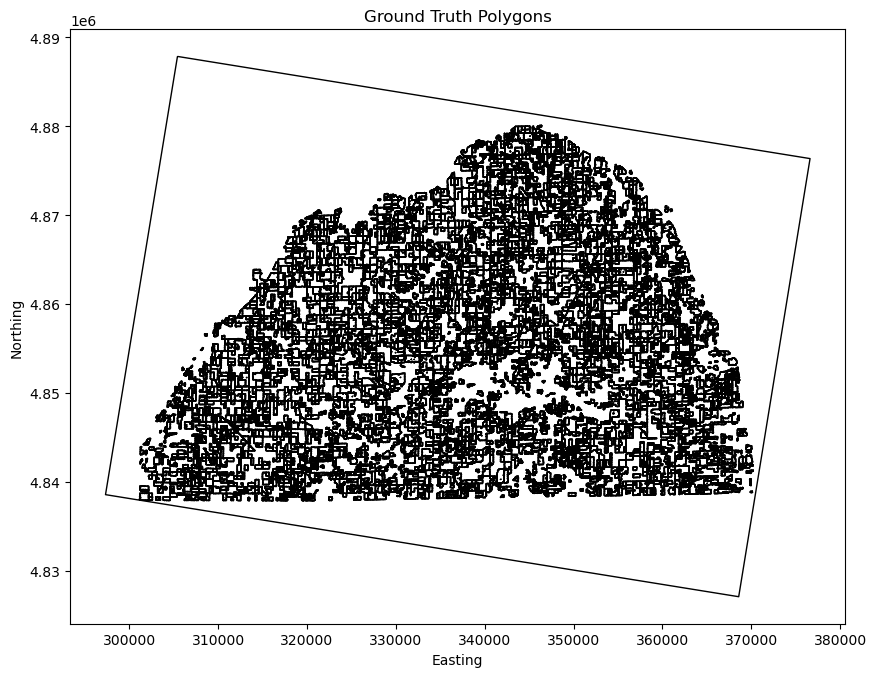

In [67]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the ground truth shapefile.
gt_path = "/Users/chandana/Downloads/cdl_huron_polygon.shp"
gt_vector = gpd.read_file(gt_path)

# Print basic information.
print("Ground Truth CRS:", gt_vector.crs)
print("Total number of features:", len(gt_vector))
print("Bounds:", gt_vector.total_bounds)  # (minx, miny, maxx, maxy)

# Visualize the ground truth.
fig, ax = plt.subplots(figsize=(10, 10))
gt_vector.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1)
ax.set_title("Ground Truth Polygons")
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
plt.show()


{'Total Predicted Mask Area (pixels)': 12612888, 'Total Polygon Area (pixels)': 12296928, 'Overlapping Area (pixels)': 9591847, 'Overlap % of Raster': '76.05%', 'Overlap % of Polygons': '78.00%'}


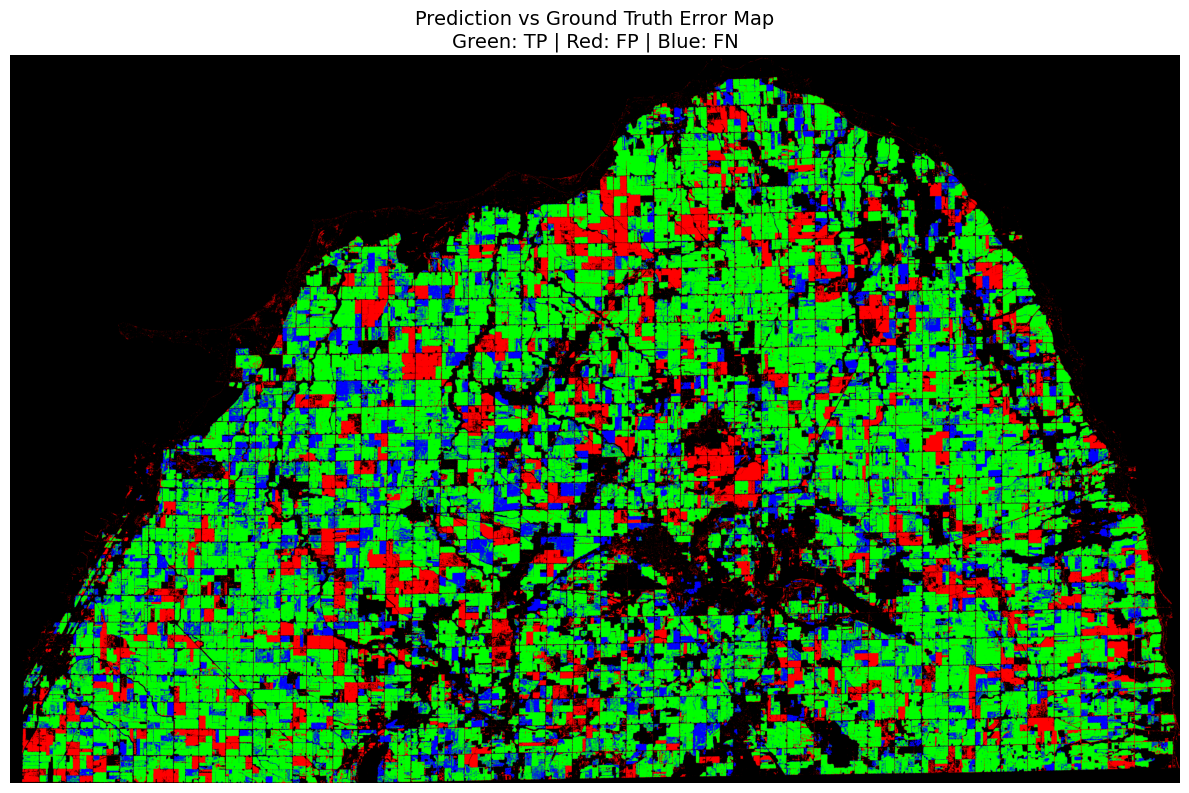

In [69]:
import fiona
import numpy as np
import rasterio
import shapely.ops
from shapely.geometry import shape, Polygon, MultiPolygon, mapping
from pyproj import Transformer, CRS
import matplotlib.pyplot as plt
import rasterio.plot
from rasterio.features import geometry_mask


shapefile_path = "/Users/chandana/Downloads/new_cdl_polygons.shp"
predicted_mask_path = "/Users/chandana/Downloads/Stacked_Files/Huron_County_Prediction.tif"

projected_geometries = []
transformer = Transformer.from_crs("EPSG:5070", "EPSG:32617", always_xy=True)

with fiona.open(shapefile_path, 'r') as src:
    for feature in src:
        crop_class = feature['properties'].get('DN')
        if crop_class is not None and crop_class > 0:
            geom = shape(feature['geometry'])
            if geom.is_valid and isinstance(geom, (Polygon, MultiPolygon)):
                geom_proj = shapely.ops.transform(transformer.transform, geom)
                projected_geometries.append(geom_proj)


with rasterio.open(predicted_mask_path) as src:
    raster_bounds = src.bounds
    raster_array = src.read(1)
    raster_transform = src.transform
    raster_crs = src.crs


minx, miny, maxx, maxy = np.inf, np.inf, -np.inf, -np.inf
for geom in projected_geometries:
    gxmin, gymin, gxmax, gymax = geom.bounds
    minx = min(minx, gxmin)
    miny = min(miny, gymin)
    maxx = max(maxx, gxmax)
    maxy = max(maxy, gymax)

vector_bounds_reprojected = (minx, miny, maxx, maxy)



polygon_mask = geometry_mask(
    geometries=[mapping(geom) for geom in projected_geometries],
    transform=raster_transform,
    invert=True,
    out_shape=raster_array.shape
)



overlap_area = np.logical_and(polygon_mask, raster_array == 1).sum()
raster_total = (raster_array == 1).sum()
polygon_total = polygon_mask.sum()

overlap_pct_of_raster = 100 * overlap_area / raster_total if raster_total else 0
overlap_pct_of_polygon = 100 * overlap_area / polygon_total if polygon_total else 0

print({
    "Total Predicted Mask Area (pixels)": raster_total,
    "Total Polygon Area (pixels)": polygon_total,
    "Overlapping Area (pixels)": overlap_area,
    "Overlap % of Raster": f"{overlap_pct_of_raster:.2f}%",
    "Overlap % of Polygons": f"{overlap_pct_of_polygon:.2f}%"
})


# Create masks
tp_mask = np.logical_and(polygon_mask, raster_array == 1)   # True Positives
fp_mask = np.logical_and(~polygon_mask, raster_array == 1)  # False Positives
fn_mask = np.logical_and(polygon_mask, raster_array == 0)   # False Negatives

# Create RGB overlay
overlay_rgb = np.zeros((raster_array.shape[0], raster_array.shape[1], 3), dtype=np.uint8)
overlay_rgb[tp_mask] = [0, 255, 0]    # Green: TP
overlay_rgb[fp_mask] = [255, 0, 0]    # Red: FP
overlay_rgb[fn_mask] = [0, 0, 255]    # Blue: FN

# Plot error map
fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(overlay_rgb)
ax.set_title("Prediction vs Ground Truth Error Map\nGreen: TP | Red: FP | Blue: FN", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

In [70]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Step 1: Flatten inputs
y_true = polygon_mask.flatten().astype(int)  # 1 = actual field, 0 = background
y_pred = (raster_array == 1).flatten().astype(int)  # 1 = predicted field

# Step 2: Confusion matrix & classification report
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred, target_names=['Background', 'Field'], output_dict=True)

# Step 3: Pixel-level metrics
TP = conf_matrix[1][1]
FP = conf_matrix[0][1]
FN = conf_matrix[1][0]
TN = conf_matrix[0][0]

intersection = TP
union = TP + FP + FN
iou = intersection / union if union else 0
pixel_accuracy = TP / (TP + FN) if (TP + FN) else 0

# Step 4: Acreage calculation
PIXEL_AREA_M2 = 100  # for 10m resolution
SQM_TO_ACRES = 1 / 4046.86

total_pred_pixels = (raster_array == 1).sum()
total_poly_pixels = polygon_mask.sum()

pred_area_m2 = total_pred_pixels * PIXEL_AREA_M2
true_area_m2 = total_poly_pixels * PIXEL_AREA_M2

pred_area_acres = pred_area_m2 * SQM_TO_ACRES
true_area_acres = true_area_m2 * SQM_TO_ACRES

error_acres = abs(pred_area_acres - true_area_acres)
error_percent = (error_acres / true_area_acres * 100) if true_area_acres else 0

# Step 5: Display results
metrics = {
    "Confusion Matrix": {
        "True Negative (Background)": int(TN),
        "False Positive": int(FP),
        "False Negative": int(FN),
        "True Positive (Field)": int(TP),
    },
    "Classification Report": {
        "Precision (Field)": f"{class_report['Field']['precision']:.2f}",
        "Recall (Field)": f"{class_report['Field']['recall']:.2f}",
        "F1-Score (Field)": f"{class_report['Field']['f1-score']:.2f}",
        "Overall Accuracy": f"{class_report['accuracy']:.2f}"
    },
    "Pixel-Level Metrics": {
        "Pixel Accuracy (Recall)": f"{pixel_accuracy:.2%}",
        "IoU (Jaccard Index)": f"{iou:.2%}"
    },
    "Acreage Comparison": {
        "Predicted Acreage": round(pred_area_acres, 2),
        "Shapefile Acreage": round(true_area_acres, 2),
        "Acreage Error": round(error_acres, 2),
        "Error Percentage": f"{error_percent:.2f}%"
    }
}

import pprint
pprint.pprint(metrics)

{'Acreage Comparison': {'Acreage Error': 7807.53,
                        'Error Percentage': '2.57%',
                        'Predicted Acreage': 311670.97,
                        'Shapefile Acreage': 303863.44},
 'Classification Report': {'F1-Score (Field)': '0.77',
                           'Overall Accuracy': '0.81',
                           'Precision (Field)': '0.76',
                           'Recall (Field)': '0.78'},
 'Confusion Matrix': {'False Negative': 2705081,
                      'False Positive': 3021041,
                      'True Negative (Background)': 15298141,
                      'True Positive (Field)': 9591847},
 'Pixel-Level Metrics': {'IoU (Jaccard Index)': '62.62%',
                         'Pixel Accuracy (Recall)': '78.00%'}}


In [71]:
import time
import pickle
import psutil


# 1. Training Time
start_train = time.perf_counter()
clf_mt.fit(X_train, y_train)
training_time = time.perf_counter() - start_train

# 2. Model Complexity
depths = [est.tree_.max_depth for est in clf_mt.estimators_]
nodes = [est.tree_.node_count for est in clf_mt.estimators_]
avg_depth = sum(depths) / len(depths)
avg_nodes = sum(nodes) / len(nodes)

# 3. Inference Time
start_infer = time.perf_counter()
_ = clf_mt.predict(X_val)
inference_time = time.perf_counter() - start_infer

# 4. Hardware Requirements
cpu_count = psutil.cpu_count(logical=True)
total_ram_gb = psutil.virtual_memory().total / (1024**3)

# 5. Model Size
model_bytes = pickle.dumps(clf_mt)
model_size_mb = len(model_bytes) / (1024**2)

# Output
print(f"Training Time: {training_time:.4f} s")
print(f"Average Tree Depth: {avg_depth:.2f}")
print(f"Average Nodes/Tree: {avg_nodes:.2f}")
print(f"Inference Time: {inference_time:.4f} s")
print(f"CPU Cores: {cpu_count}")
print(f"System RAM: {total_ram_gb:.2f} GB")
print(f"Model Size: {model_size_mb:.2f} MB")


Training Time: 37.0891 s
Average Tree Depth: 33.06
Average Nodes/Tree: 7535.48
Inference Time: 0.3579 s
CPU Cores: 8
System RAM: 16.00 GB
Model Size: 59.37 MB
